In [63]:
# Loading necessary modules.
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from os import fspath
%matplotlib inline
import seaborn as sns
import math
import pandas as pd
import MDAnalysis as mda
from MDAnalysis.analysis.align import AlignTraj
from MDAnalysis.analysis.align import AverageStructure
from MDAnalysis.analysis.rms import RMSD, RMSF
from MDAnalysis.analysis.pca import PCA, cosine_content
from MDAnalysis.analysis import diffusionmap
from MDAnalysis.transformations.positionaveraging import PositionAverager
import pandas as pd

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform
import matplotlib.patches as patches

In [64]:
comm_path = "/home/giacomo/comp_bio/cbp_final/data_other/umbrella/02_processed/simulations_nbc/"
sim = [0,17,35,70,104,124,139,145,148,149,150,166,180,206,224,236,249,272,291,313,327,351,368,403]

In [74]:
sel_prot = "protein"
sel_mtx = "resname MTX"
d = []
sd = []
dx = []
dy = []
dz = []
sdx = []
sdy = []
sdz = []
rmsds = []
rmsds_noloop = []
for sn in sim:
    print(sn)
    sim_number = str(sn)
    config_file = comm_path + "sim_" + sim_number + ".tpr"
    traj_file = comm_path + "sim_" + sim_number + "_nbc.xtc"
    aligned_traj_file = comm_path + "sim_" + sim_number + "_cat.xtc"

    # alignment
    if False: 
        traj = mda.Universe(config_file, traj_file)
        av = AverageStructure(traj, ref_frame=0).run()
        aligner = AlignTraj(traj,av.results.universe,select="name CA", filename = aligned_traj_file)    
        aligner.run()

    #loading
    aligned_traj = mda.Universe(config_file, aligned_traj_file)
    ref_traj = mda.Universe(config_file, aligned_traj_file)    
    ref_traj.trajectory[0]

    #selections
    prot = aligned_traj.select_atoms(sel_prot)
    mtx = aligned_traj.select_atoms(sel_mtx)

    d_avg = 0
    d_avgsq = 0
    dx_avg = 0
    dx_avgsq = 0
    dy_avg = 0
    dy_avgsq = 0
    dz_avg = 0
    dz_avgsq = 0
    nframes = aligned_traj.trajectory.n_frames

    # average and variance of the center of mass distance
    for ts in aligned_traj.trajectory[:]:
        cm_prot = prot.center_of_mass()
        cm_mtx = mtx.center_of_mass()
        dist_vsq = ((cm_prot-cm_mtx)**2)
        dist_v = cm_prot-cm_mtx
        dist = np.sqrt(dist_vsq.sum())
        d_avg = d_avg + dist / nframes
        d_avgsq = d_avgsq + d_avg*d_avg / nframes
        dx_avg = (dist_v[0]) / nframes
        dx_avgsq = dist_vsq[0] / nframes
        dy_avg = (dist_v[1]) / nframes
        dy_avgsq = dist_vsq[1] / nframes
        dz_avg = (dist_v[2]) / nframes
        dz_avgsq = dist_vsq[2] / nframes

    d.append(d_avg)
    sd.append(d_avg**2-d_avgsq)
    dx.append(dx_avg)
    sdx.append(dx_avg**2-dx_avgsq)
    dy.append(dy_avg)
    sdy.append(dy_avg**2-dy_avgsq)
    dz.append(dz_avg)
    sdz.append(dz_avg**2-dz_avgsq)

    # rmsd
    R = RMSD(aligned_traj, ref_traj, select="protein").run()
    rmsds.append(R.results.rmsd[:,2])
    R2 = RMSD(aligned_traj, ref_traj, select="protein and not resid 18 to 27 and not resid 41 to 46").run()
    rmsds_noloop.append(R2.results.rmsd[:,2])


0
17
35
70
104
124
139
145
148
149
150
166
180
206
224
236
249
272
291
313
327
351
368
403


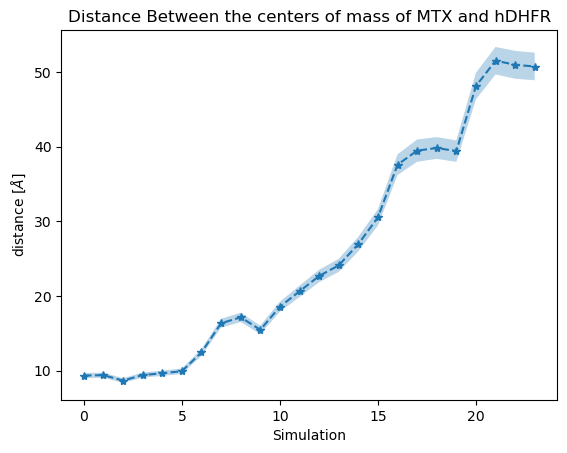

In [75]:
ordinate = np.arange(len(sim))
error = np.sqrt(np.array(sd)/500)

plt.title("Distance Between the centers of mass of MTX and hDHFR")
plt.plot(ordinate, d, "*--")
plt.fill_between(ordinate, d - error, d + error, alpha = 0.3)
plt.xlabel("Simulation")
plt.ylabel(r"distance $[\AA]$")
plt.show()

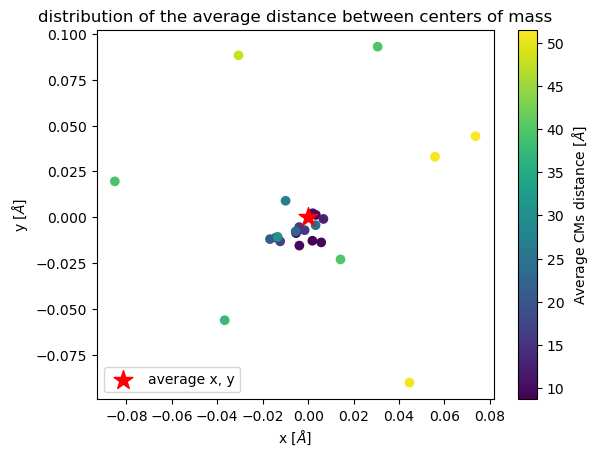

In [90]:
avg_x = np.average(dx)
avg_y = np.average(dy)

plt.title("distribution of the average distance between centers of mass")
scatter = plt.scatter(dx, dy, c = d)
plt.scatter(avg_x, avg_y, color='red', marker='*', s=200, label="average x, y")
plt.colorbar(scatter, label = r'Average CMs distance $[\AA]$')
plt.xlabel(r"x $[\AA]$")
plt.ylabel(r"y $[\AA]$")
plt.legend()
plt.show()

In [ ]:
count = 0
for rmsd, i, dist in zip(rmsds_noloop, sim, d):
    if count % 5 == 0:
        plt.plot(np.arange(len(rmsd)) / 100, rmsd, label = f"{i}-th frame, CMs distance: {dist:.2f} $[\\AA]$")
    else: 
        pass
        # plt.plot(np.arange(len(rmsd)) / 100, rmsd)
    count += 1
plt.legend()
plt.title("RMSD of some umbrella sampling simulations")
plt.xlabel("time [ns]")
plt.ylabel(r"RMSD $[\AA]$")
plt.show()

In [ ]:
count = 0
for rmsd, i, dist in zip(rmsds_noloop, sim, d):
    if i == 313:
        plt.plot(np.arange(len(rmsd)) / 100, rmsd, label = f"{i}-th frame, CMs distance: {dist:.2f} $[\\AA]$")
    else: 
        plt.plot(np.arange(len(rmsd)) / 100, rmsd)
    count += 1
plt.legend()
plt.title("RMSD of every umbrella sampling simulations")
plt.xlabel("time [ns]")
plt.ylabel(r"RMSD $[\AA]$")
plt.show()